# "Reverse mode autodiff"
> "Understand how machine learning frameworks implement autodiff"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Saibaba Telukunta
- categories: [autodiff, autograd, gradient, partial-derivative, chain-rule]

Introduction
--

Gradient descent (GD) is the main workhorse of deep neural networks. When you work with higher level machine learning frameworks like Pytorch or Tensorflow, it is hidden under the layers and you do not get to understand or appreciate how it works. The GD itself is implemented using something called reverse mode AD (called autodiff in rest of the doc).

When you start using the low level libraries in pytorch or tensorflow you end up using constructs like `forward`, `backward`, `tape` and so on. Following is my attempt to demystify autodiff starting from ground up as well as to gain an understading of these terms.

This article proceeds as below:
* Starts from hard-coded gradient calculation for a loss function in estimating a parameter for a model. 
* Add reverse mode autodiff functionality to demonstrate how it can generically calculate the (partial) derivative of a loss function.
* Pytorch built-in autograd is used to demonstrate the same features.
* For comparison, the same functionality is implemented using tensorflow.


**Sample problem**

The problem being tackled is to estimate the exponent of a function $y = f(x) = x^\theta$ from a set of sample $(x_i, y_i)$.

Let's use the RMSE as the loss function and want to find the $\theta$ that minimizes it:

RMSE loss = $L(\theta) = \sqrt{\frac{\sum_{i=1}^n (x_i^\theta - y_i)^2}{n}}$

So, its gradient:

$\frac{\partial L}{\partial \theta} = \frac{1}{2} \frac{\frac{1}{n} \sum_{i=1}^n 2 (x_i^\theta - y_i) ln(x_i) x_i^\theta}{\sqrt{\frac{\sum_{i=1}^n (x_i^\theta - y_i)^2}{n}}}$

Above gradient when used in batch gradient descent, we use below equation to update $\theta$:

$\theta^{new} = \theta^{old} - lr * \frac{\partial L}{\partial \theta}$

In stochastic gradient descent (SGD), gradient is calculated and the current $\theta$ is updated for each of the training samples, so it simplifies to:

RMSE loss for sample, i = $L_i(\theta) = \sqrt{(x_i^\theta - y_i)^2}$

$\frac{\partial L_i}{\partial \theta} = \frac{1}{2} \frac{2 (x_i^\theta - y_i) ln(x_i) x_i^\theta}{\sqrt{(x_i^\theta - y_i)^2}}$

(Let's ignore for now that we really do not need to take square root in this case since there is only one sample).

$\theta^{new} = \theta^{old} - lr * \frac{\partial L_i}{\partial \theta}$

First let's create some sample data from the actual model.


In [1]:
import torch

def sample(count, theta):
    xs = torch.rand(count) * 10
    ys = xs.pow(theta)
    return xs, ys

x_train, y_train = sample(10, 1.5)

So the actual value of $\theta$ is 1.5 and we are going to estimate it from the samples.

Following is a utility function to plot losses and exponent discovered in each epoch.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_and_exponent(loss_history, theta_history):
    fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    for ax in [ax1, ax2]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
        ax.tick_params(direction='out', color='b', width='2')
        
    ax1.set_title('Loss(RMSE)')
    ax2.set_title('Exponent')
    ax1.plot(np.arange(len(loss_history)), loss_history)
    ax2.plot(np.arange(len(theta_history)), theta_history)

Naive solution with hand coded gradient descent
---

First we build our own function that calculates gradient descent directly using above formula.

In [3]:
def dLoss(x, y, theta_hat):
    n = len(x)
    w = (x.pow(theta_hat) - y) * torch.log(x) * x.pow(theta_hat)
    num = torch.sum(w)/n
    z = (x.pow(theta_hat) - y).pow(2)
    denom = torch.sqrt(sum(z)/n)
    return num/denom

**Batch GD**

Here all data is used per update of $\theta$.

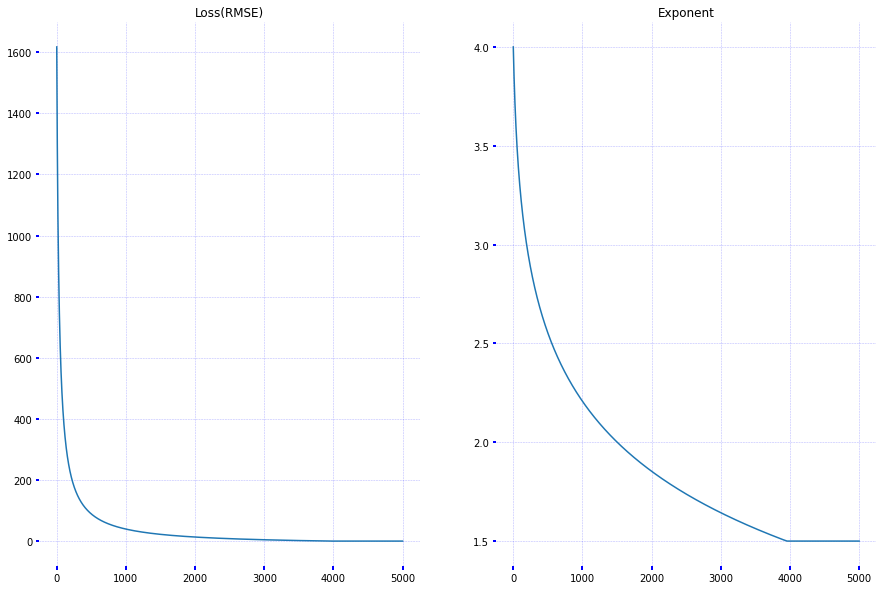

In [4]:
import torch
from torch.autograd import Variable
import numpy as np

def rmse(y, y_hat):
    return torch.sqrt(torch.mean((y-y_hat).pow(2)))

# fancy name for function evaluation
def forward(x, theta):
    return x.pow(theta.repeat(x.size(0)))

# Calculate gradient of loss w.r.t. 
# Its semantics are not exactly that of pytorch or tensorflow, but keeping this name as it is the closest.
def backward(x_train, y_train, theta_hat):
    return dLoss(x_train, y_train, theta_hat)

def optimizer_step(theta_hat, lr, grad):
    return theta_hat - lr * grad

lr = 5e-6
n_epoch = 5000

theta_hat = torch.FloatTensor([4.0])

loss_history = []
theta_history = []

for epoch in range(n_epoch):
    
    y_hat = forward(x_train, theta_hat)
    loss = rmse(y_train, y_hat)
    grad = backward(x_train, y_train, theta_hat)
    
    loss_history.append(loss)
    theta_history.append(theta_hat)
    theta_hat = optimizer_step(theta_hat, lr, grad)

plot_loss_and_exponent(loss_history, theta_history)

**Stochastic Gradient Descent(SGD)**

Here only one sample is used per update of $\theta$.


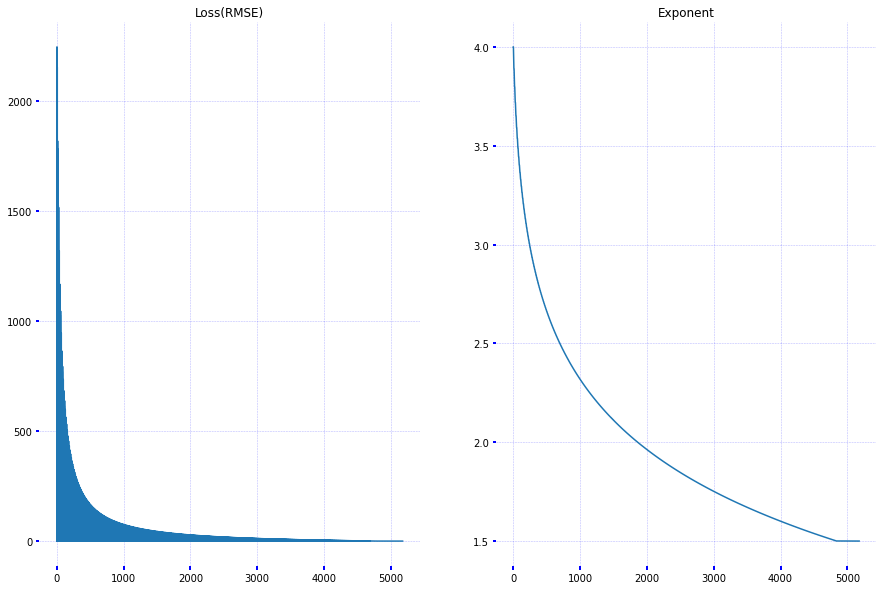

In [5]:
# SGD
import random

def rmse(y, y_hat):
    return torch.sqrt((y-y_hat).pow(2))

def forward(x, theta):
    return x.pow(theta)

def backward(x_train, y_train, theta_hat):
    return dLoss(x_train, y_train, theta_hat)

def optimizer_step(theta_hat, lr, grad):
    return theta_hat - lr * grad

lr = 5e-6
n_epoch = 2000

theta_hat = torch.FloatTensor([4.0])

loss_history = []
theta_history = []

for epoch in range(n_epoch):

    # Ideally we need to shuffle training samples in each epoch to let SGD converge close to global minimum.
    # It dies not matter in our case as they are not sorted in any order.
    # In general, in a classification problem the training examples might be sorted by label and to 
    # ensure IID condition we need to shuffle them).
    for xi, yi in zip(x_train, y_train):
        y_hat = forward(xi, theta_hat)
        loss = rmse(torch.tensor([yi]), torch.tensor([y_hat]))
        grad = backward(torch.tensor([xi]), torch.tensor([yi]), theta_hat)
        
        loss_history.append(loss)
        theta_history.append(theta_hat)

        theta_hat = optimizer_step(theta_hat, lr, grad)

plot_loss_and_exponent(loss_history, theta_history)

Home grown reverse mode autodiff(AD)
--

As can be seen from above example, for every kind of loss function, implementing gradient descent by hand is not optimal and error prone and boring. Can it be automated ? Let's walk through an example to see how this can be done using something called reverse mode AD.

Let's use SGD RMSE loss function from the introduction above:

$L_i(\theta) = \sqrt{(x_i^\theta - y_i)^2}$

$\frac{\partial L_i}{\partial \theta} = \frac{1}{2} \frac{2 (x_i^\theta - y_i) ln(x_i) x_i^\theta}{\sqrt{(x_i^\theta - y_i)^2}}$

The goal of autodiff is create a generic mechanism to evaluate gradient of any function without writing code for it for every expression. Reverse mode AD is one way to do it and it depends on partial derivatives and chain rule heavily. Forward mode AD is another mechainsm and we do not talk about it in this article.

To be able to automatically calculating derivatives of arbitrary expressions, we have to first define some primitive expressions and then build complex ones out of them. There are a lot of function compositions in above RMSE equation. Breaking into simpler functions starting from primitives and using function composition:

$v_0 = \theta$ constant

$v_1(v_0) = x^{v_0}$

$v_2 = y_i$ constant function

$v_3(v_1, v_2) = v_1 - v_2$

$v_4(v_3) = v_3^2$

$v_5(v_4) = \sqrt{v_4}$

$L_i = v_5 = L(v_5)$ (for simplifying the expressions below).

So, if you are calculating the (total) derivative of $L$ w.r.t. $\theta$ how do you do it by hand? We use chain rule as follows:


$\begin{aligned}\frac{\partial L}{\partial \theta}
&= \frac{\partial L}{\partial v_5} \frac{\partial v_5}{\partial \theta} \\ 
&= \frac{\partial L}{\partial v_5} (\frac{\partial v_5}{\partial v_4} \frac{\partial v_4}{\partial \theta}) \\
&= \frac{\partial L}{\partial v_5} (\frac{\partial v_5}{\partial v_4} (\frac{\partial v_4}{\partial v_3} \frac{\partial v_3}{\partial \theta} )) \\
&= \frac{\partial L}{\partial v_5} (\frac{\partial v_5}{\partial v_4} (\frac{\partial v_4}{\partial v_3} (\frac{\partial v_3}{\partial v_1} \frac{\partial v_1}{\partial \theta} + \frac{\partial v_3}{\partial v_2} \frac{\partial v_2}{\partial \theta}))) \\
&= \dots \\
\end{aligned}$


The most important aspect of reverse mode AD is realizing that we can rewrite above as:

$\begin{aligned}\frac{\partial L}{\partial \theta}
&= (((((\frac{\partial L}{\partial v_5}) \frac{\partial v_5}{\partial v_4}) \frac{\partial v_4}{\partial v_3}) \frac{\partial v_3}{\partial v_1} \frac{\partial v_1}{\partial \theta}) + (((((\frac{\partial L}{\partial v_5}) \frac{\partial v_5}{\partial v_4}) \frac{\partial v_4}{\partial v_3}) \frac{\partial v_3}{\partial v_2} \frac{\partial v_2}{\partial \theta})
\end{aligned}$

Execution happens from the innermost parenthesis and procceds outwards.

If we imagine that each function ($v_i$) knows how to find the derivative of its output w.r.t to its input, the expansion above shows a pattern that can be leveraged to compute derivative:

Imagine that each operation/function is implemented as a class. For example consider $v_i$. It's class implements a function say `backward` that takes in the input $\frac{\partial L}{\partial v_i}$. For each if its inputs, it calculates the derivative of output with respect to that input, multiplies with this input and returns the result. For example, consider $v_5$. The `backward` function takes $\frac{\partial L}{\partial v_5}$ in the input, computes derivative $\frac{\partial v_5}{\partial v_4} = \frac{1}{2} \frac{1}{\sqrt{v_4}}$ and returns the product $\frac{\partial L}{\partial v_4} = \frac{\partial L}{\partial v_5} * \frac{\partial v_5}{\partial v_4}$.


If a function like $v_3$ takes 2 inputs, it computes partial derivative w.r.t. each of the inputs and returns the list of updated derivatives.

For example, consider $v_3$.
It takes $\frac{\partial L}{\partial v_3}$ and returns (1) $\frac{\partial L}{\partial v_1}$ and (2) $\frac{\partial L}{\partial v_2}$.

Now we need a driver function, say `backprop` that orchestrates this sequence of `backward` calls starting from the target ($L = v_5$) and does a BFS on the expression to propagate down the derivatives until leaves are reached ($v_0$ in above example). Also, when it receives multiple outputs on calling a function (like `backward` on $v_3$ above), it correctly propagates the derivatives to the corresponding input variables (like to $v_1$ and $v_2$ respectively).

In [6]:
import json
import torch

# Instead of creating a separate Expr class for each operation,
# we leverage python operator overloading and create only one class Var. The downside is that now we have only
# one class but with different derivative calculation based on the operation performed. So, we store the
# derivative calculation as a lambda function in derivatives variable.

# Note that I have intentially not abstracted too much in Var class - I do not want to hide the necessary 
# aspects needed to use reverse mode autodiff, but rather expose them so as to understand it better.

class Var:
    def __init__(self, name, value):
        self.value = value
        self.name = name
        self.derivatives = []
        self.grad_value = None
        self.is_leaf = False
        self.is_const = False
    
    def __str__(self):
        return "name=" + self.name + "; value = " + str(self.value)

    def __mul__(self, v2):
        v1 = self
        v = Var(v1.name + "*" + v2.name, v1.value * v2.value)
        v.derivatives.append( (v1, lambda og : og * v2.value) )
        v.derivatives.append ( (v2, lambda og : og * v1.value) )        
        return v

    def __add__(self, v2):
        v1 = self
        v = Var(v1.name + "+" + v2.name, v1.value + v2.value)
        v.derivatives.append ( (v1, lambda og : og ) )
        v.derivatives.append ( (v2, lambda og : og ) )
        return v

    def __sub__(self, v2):
        v1 = self
        v = Var(v1.name + "-" + v2.name, v1.value - v2.value)
        v.derivatives.append ( (v1, lambda og : og ) )
        v.derivatives.append ( (v2, lambda og : -og ) )
        return v

    def __pow__(self, v2):
        v1 = self
        v = Var(v1.name + "-" + v2.name, v1.value ** v2.value)        
        v.derivatives.append( (v1, lambda og : og * v2.value * (v1.value ** (v2.value-1))))
        v.derivatives.append ( (v2, lambda og : og * v.value * torch.log(torch.tensor([v1.value]))) )        
        return v
    
    def backward(self, output_gradient = None):
        
        if output_gradient is None:
            output_gradient = 1.0

        if self.is_const:
            self.grad_value = 0
            return self

        if not self.is_leaf:
            return [(var, fn(output_gradient)) for var, fn in self.derivatives]
        else:
            if self.grad_value is None:
                self.grad_value = output_gradient
            else:
                self.grad_value += output_gradient
            return self
    
def sin(v):
    r = Var("sin(" + v.name + ")", torch.sin(torch.tensor([v.value])))
    r.derivatives.append ((v, lambda og : og*torch.cos(torch.tensor([v.value]))))
    return r

def sqrt(v):
    r = Var("sqrt(" + v.name + ")", torch.sqrt(torch.tensor([v.value])))
    r.derivatives.append ((v, lambda og : og*0.5/r.value))
    return r

def dx1(x1, x2):
    return x2 + torch.cos(torch.tensor([x1]))

def dx2(x1, x2):
    return x1

# logic of backprop could be hosted in the Var.backward
def backprop(loss):
    gradients = loss.backward()
    q = [g for g in gradients]

    while len(q) > 0:
        var, input_gradient = q.pop()
        gradients = var.backward(input_gradient)
        if not var.is_leaf:
            for g in gradients:
                q.append(g)

**Some example exeuctions to check correct working**

In [7]:
x1 = Var("x1", 0.50)
x1.is_leaf = True
x2 = Var("x2", 4.2)
x2.is_leaf = True

y = (x1 * x2) + sin(x1)

print('Expected dx1 should be', dx1(x1.value, x2.value))
print('Expected dx2 should be', dx2(x1.value, x2.value))

backprop(y)
print(x1.grad_value)
print(x2.grad_value)

Expected dx1 should be tensor([5.0776])
Expected dx2 should be 0.5
tensor([5.0776])
0.5


In [8]:
x = Var("x", 3.0)
one = Var("1", 1.0)
x.is_leaf = True
one.is_leaf = True
one.is_const = True

y = (x * x * x) + (x * x) + one
backprop(y)
print(x.grad_value)
print(one.grad_value)

33.0
0


In [9]:
theta = Var("theta", 4.0)
theta.is_leaf = True
x = Var("x", 3.0)
x.is_leaf = True
x.is_const = True

y = x ** theta
backprop(y)
print(theta.grad_value)
# verify with: https://www.wolframalpha.com/input/?i=derivative+of+3%5Ex+where+x+%3D4

tensor([88.9876])


In [10]:
x = Var("x", 4.0)
x.is_leaf = True

y = sqrt(x)
backprop(y)
print(x.grad_value)

tensor([0.2500])


In [11]:
theta = Var("theta", 4.0)
theta.is_leaf = True
two = Var("two", 2.0)
two.is_leaf = True
two.is_const = True

def rmse(y, y_hat):
    return sqrt((y-y_hat) ** two)

def forward(x, theta):
    return x ** theta

y = Var("y", 2.828)
y_hat = Var("y_hat", 2.3)

print(rmse(y, y_hat))

name=sqrt(y-y_hat-two); value = tensor([0.5280])


Finally, let's apply this to the SGD of our exponent estimator:

In [12]:
import random

two = Var("two", 2.0)
two.is_leaf = True
two.is_const = True


def loss(y, y_hat):
    return sqrt((y-y_hat) ** two)

def forward(x, theta):
    return x ** theta

def backward(err):
    backprop(err)
    return

def optimizer_step(theta, lr, grad):
    return theta - lr * grad

lr = Var("lr", 5e-6)
lr.is_leaf = True
lr.is_const = True

theta = Var("theta", 4.0)
theta.is_leaf = True


n_epoch = 5000
loss_history = []
theta_history = []

for epoch in range(n_epoch):
    
    temp = list(zip(x_train, y_train))
    random.shuffle(temp)
    a, b = zip(*temp)

    for xi, yi in zip(a, b):
        var_xi = Var("xi", xi)
        var_xi.is_leaf = True
        var_xi.is_const = True
        y_hat = forward(var_xi, theta)
        var_yi = Var("yi", yi)
        var_yi.is_leaf = True
        var_yi.is_const = True
        
        err = loss(var_yi, y_hat)
        backward(err)
        
        loss_history.append(err.value)
        theta_history.append(theta.value)

        var_grad = Var("grad", theta.grad_value)
        var_grad.is_leaf = True
        var_grad.is_const = True
        theta = optimizer_step(theta, lr, var_grad)
        theta.name = "theta"
        theta.is_leaf = True



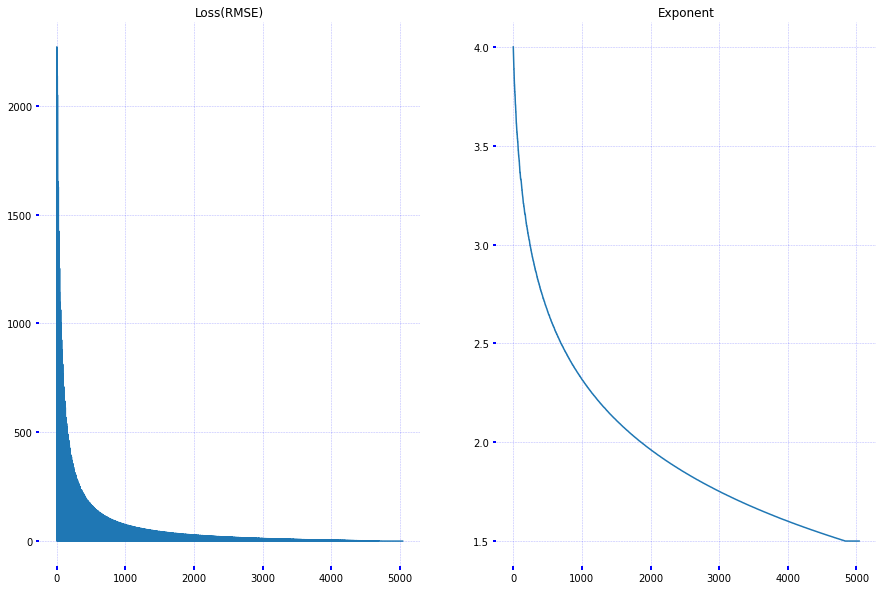

In [13]:
plot_loss_and_exponent(loss_history, theta_history)

Not bad for a demo version of the code!

Plain Pytorch autograd for autodiff
--

Let's use pytorch's autograd directly for a comparison.

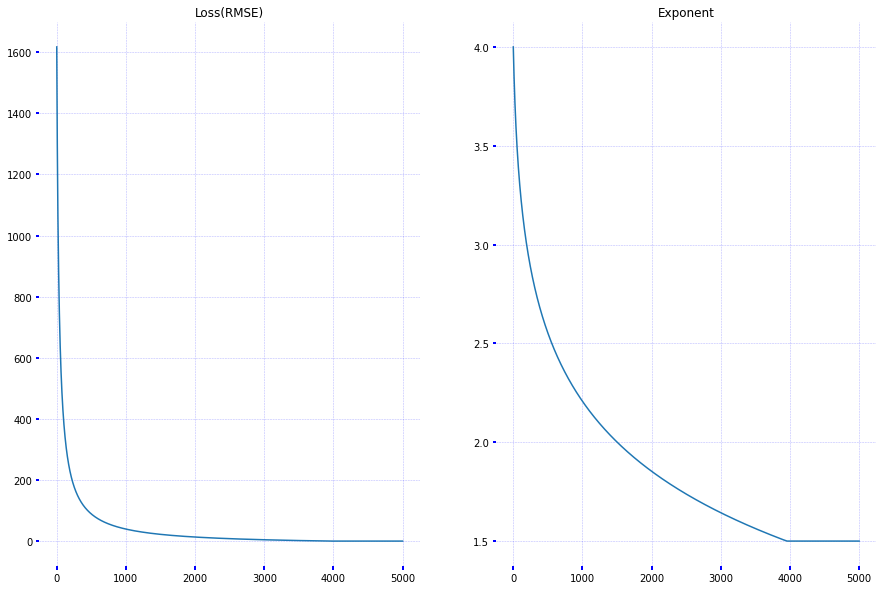

In [14]:
import torch
from torch.autograd import Variable
import numpy as np

def rmse(y, y_hat):
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

def forward(x, e):
    return x.pow(e.repeat(x.size(0)))

learning_rate = 5e-6
n_epoch = 5000

x = Variable(x_train, requires_grad=False)
y = Variable(y_train, requires_grad=False)

theta_hat = Variable(torch.FloatTensor([4]), requires_grad=True)

loss_history = []
theta_history = []

for epoch in range(n_epoch):
    
    y_hat = forward(x, theta_hat)
    
    loss = rmse(y, y_hat)
    
    loss_history.append(loss.data.item())
    theta_history.append(theta_hat.data.item())
    
    # compute dLoss/dx for every parameter x with requires_grad=True
    loss.backward()

    theta_hat.data -= learning_rate * theta_hat.grad.data
    theta_hat.grad.data.zero_()

plot_loss_and_exponent(loss_history, theta_history)

Pytorch with built-in optimizer
---

Instead of hand writing code to update the parameters, we can use built-in optimizers (with additional features like momentum that are not used in this article).

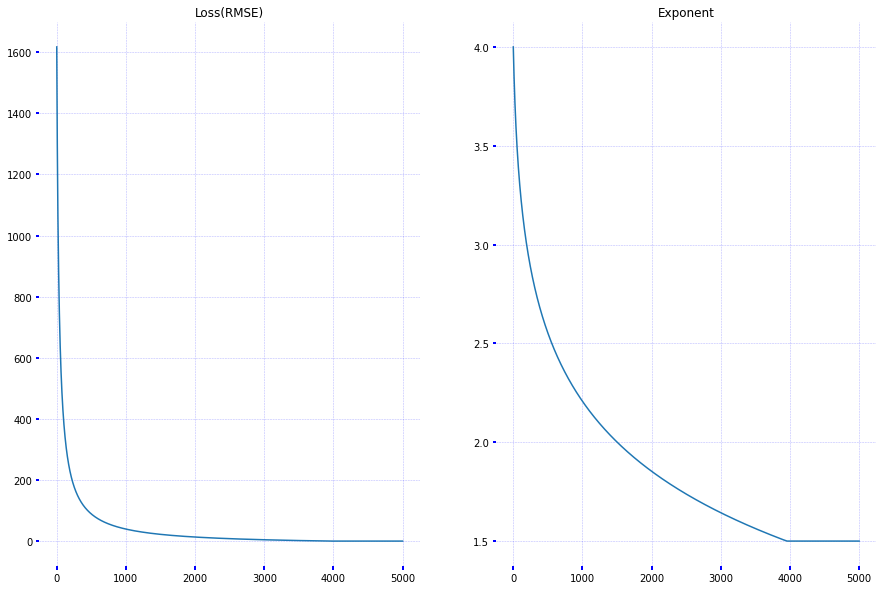

In [15]:
import torch
from torch.autograd import Variable
import numpy as np

def rmse(y, y_hat):
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

def forward(x, e):
    return x.pow(e.repeat(x.size(0)))

learning_rate = 5e-6
n_epoch = 5000

x = Variable(x_train, requires_grad=False)
y = Variable(y_train, requires_grad=False)

theta_hat = Variable(torch.FloatTensor([4]), requires_grad=True)

# Using momentum = 0 to compare results identically
opt = torch.optim.SGD([theta_hat], lr=learning_rate, momentum=0)

loss_history = []
theta_history = []

for i in range(n_epoch):
    opt.zero_grad()
    
    y_hat = forward(x, theta_hat)
    
    loss = rmse(y, y_hat)
    
    loss_history.append(loss.data.item())
    theta_history.append(theta_hat.data.item())
    
    loss.backward()
    
    # Updates the value of theta using the gradient theta.grad
    opt.step()

plot_loss_and_exponent(loss_history, theta_history)

Tensorflow
---

Now let's try the same using tensorflow autograd functions for comparison sake.

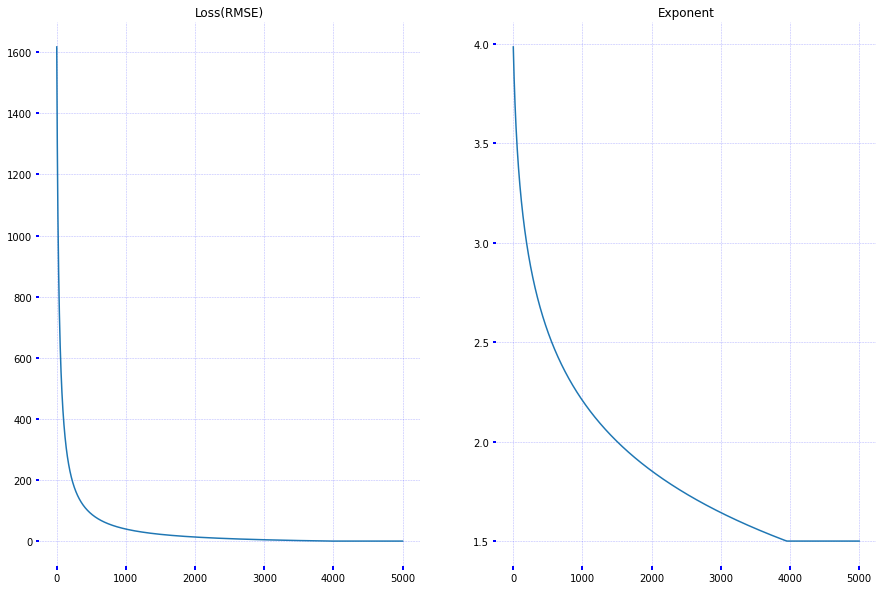

In [16]:
import tensorflow as tf

def rmse(y, y_hat):
    return tf.sqrt(tf.reduce_mean(tf.square((y - y_hat))))

def forward(x, e):
    return tf.pow(x, e)

n_epoch = 5000
learning_rate = 5e-6

x = tf.Variable(x_train)
y = tf.Variable(y_train)

theta_hat = tf.Variable(4.0, name='theta_hat')
opt = tf.keras.optimizers.SGD(learning_rate, momentum=0.0)

loss_history = []
theta_history = []

for i in range(n_epoch):        
    
    with tf.GradientTape() as tape:
        y_hat = forward(x, theta_hat)    
        loss = rmse(y, y_hat)

    grads = tape.gradient(loss, [theta_hat])
    opt.apply_gradients(zip(grads, [theta_hat]))

    loss_history.append(loss)
    theta_history.append(theta_hat.numpy())

plot_loss_and_exponent(loss_history, theta_history)

References
--

* https://jmlr.org/papers/v18/17-468.html
* https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation
* http://neuralnetworksanddeeplearning.com/chap2.html
* The exponent estimator problem is taken from this: https://towardsdatascience.com/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b